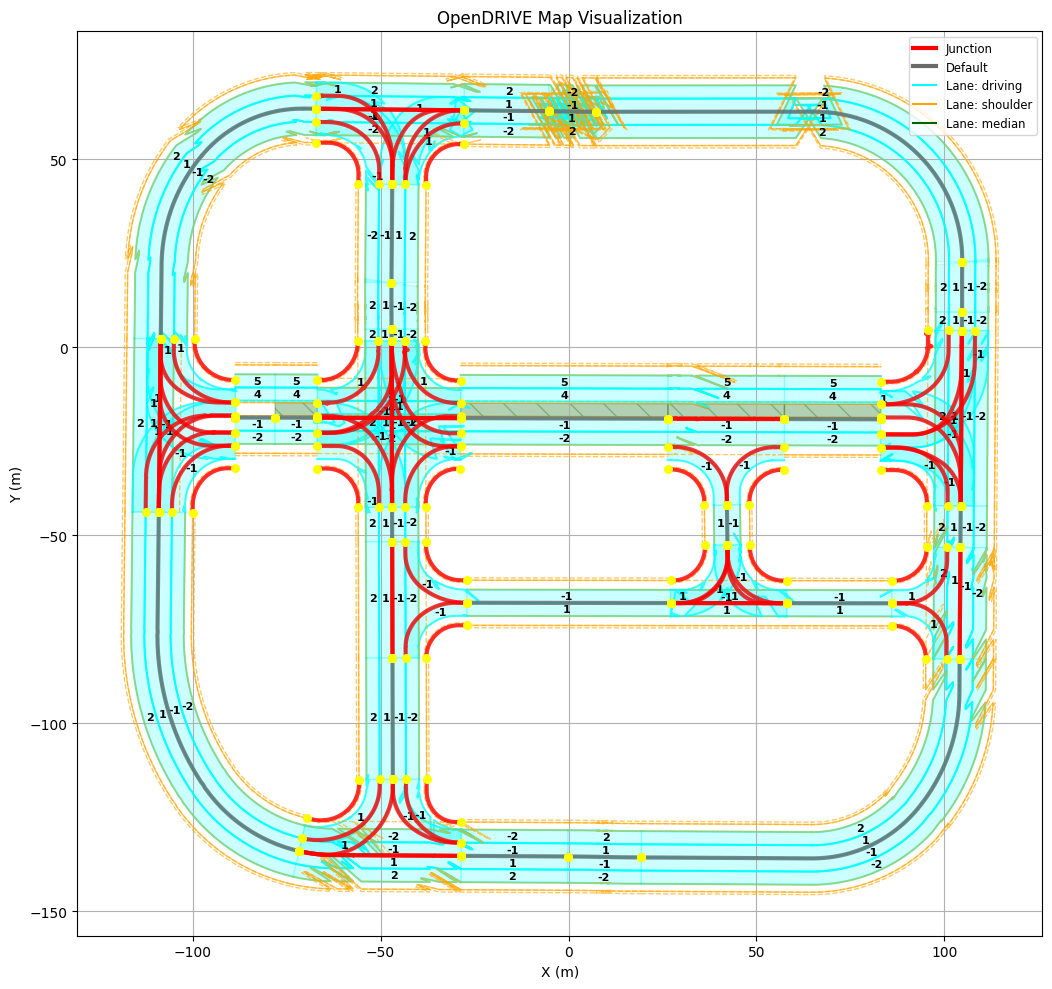

In [26]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.interpolate import splprep, splev
import math
import warnings

def visualize_xodr(xodr_path, plot_lanes=True, plot_connections=True, debug=False):
    # Parse the XML
    tree = ET.parse(xodr_path)
    root = tree.getroot()
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Prepare for better coloring and tracking
    road_colors = {}
    junction_ids = set()
    road_endpoints = {}
    road_reference_lines = {}
    road_links = {}
    
    # First identify junctions
    for junction in root.findall('.//junction'):
        junction_ids.add(junction.get('id'))
    
    # Track road links and connections
    for road in root.findall('.//road'):
        road_id = road.get('id')
        junction = road.get('junction', '-1')
        
        # Color based on road type
        if junction != '-1' and junction in junction_ids:
            road_colors[road_id] = 'red'
        else:
            road_type = road.find('type')
            if road_type is not None and road_type.get('s') == '0':
                road_type_name = road_type.get('type', '')
                if 'highway' in road_type_name:
                    road_colors[road_id] = 'blue'
                elif 'rural' in road_type_name:
                    road_colors[road_id] = 'green'
                else:
                    road_colors[road_id] = 'purple'
            else:
                road_colors[road_id] = 'dimgray'
        
        # Track road links for lane connections
        links = road.find('link')
        if links is not None:
            road_links[road_id] = {'predecessor': None, 'successor': None}
            pred = links.find('predecessor')
            if pred is not None and pred.get('elementType') == 'road':
                road_links[road_id]['predecessor'] = pred.get('elementId')
            
            succ = links.find('successor')
            if succ is not None and succ.get('elementType') == 'road':
                road_links[road_id]['successor'] = succ.get('elementId')
    
    # Process roads and road geometry
    for road in root.findall('.//road'):
        road_id = road.get('id')
        road_length = float(road.get('length', 0))
        road_points = []
        
        plan_view = road.find('planView')
        if plan_view is None:
            continue
        
        # Sort geometry elements by s-coordinate
        geometries = []
        for geom in plan_view.findall('geometry'):
            geometries.append({
                's': float(geom.get('s')),
                'x': float(geom.get('x')),
                'y': float(geom.get('y')),
                'hdg': float(geom.get('hdg')),
                'length': float(geom.get('length')),
                'element': geom
            })
        geometries.sort(key=lambda g: g['s'])
        
        # Process each geometry element
        for geom in geometries:
            try:
                x0 = geom['x']
                y0 = geom['y']
                hdg = geom['hdg']
                length = geom['length']
                element = geom['element']
                
                # Handle line segments
                line = element.find('line')
                if line is not None:
                    num_points = max(10, min(100, int(length)))  # Balance between detail and performance
                    t_range = np.linspace(0, length, num_points)
                    x_coords = x0 + np.cos(hdg) * t_range
                    y_coords = y0 + np.sin(hdg) * t_range
                    road_points.extend(list(zip(x_coords, y_coords)))
                
                # Handle arc segments
                arc = element.find('arc')
                if arc is not None:
                    curvature = float(arc.get('curvature'))
                    if abs(curvature) < 1e-10:  # Nearly straight line
                        num_points = max(10, min(50, int(length)))
                        t_range = np.linspace(0, length, num_points)
                        x_coords = x0 + np.cos(hdg) * t_range
                        y_coords = y0 + np.sin(hdg) * t_range
                    else:
                        radius = 1.0 / abs(curvature)
                        # Calculate center of the arc
                        if curvature > 0:  # Left turn
                            center_x = x0 - np.sin(hdg) * radius
                            center_y = y0 + np.cos(hdg) * radius
                            start_angle = hdg - np.pi/2
                            end_angle = start_angle + length * curvature
                        else:  # Right turn
                            center_x = x0 + np.sin(hdg) * radius
                            center_y = y0 - np.cos(hdg) * radius
                            start_angle = hdg + np.pi/2
                            end_angle = start_angle + length * curvature
                        
                        num_points = max(20, min(100, int(abs(end_angle - start_angle) * radius)))
                        angles = np.linspace(start_angle, end_angle, num_points)
                        x_coords = center_x + radius * np.cos(angles)
                        y_coords = center_y + radius * np.sin(angles)
                    road_points.extend(list(zip(x_coords, y_coords)))
                
                # Handle spiral and polynomial segments (simplified for clarity)
                spiral = element.find('spiral')
                poly3 = element.find('poly3')
                param_poly3 = element.find('paramPoly3')
                
                if spiral is not None or poly3 is not None or param_poly3 is not None:
                    # For more complex geometries, use straight approximation if needed
                    num_points = max(20, min(100, int(length)))
                    t_range = np.linspace(0, length, num_points)
                    x_coords = x0 + np.cos(hdg) * t_range
                    y_coords = y0 + np.sin(hdg) * t_range
                    road_points.extend(list(zip(x_coords, y_coords)))
            except Exception as e:
                if debug:
                    print(f"Error processing geometry for road {road_id}: {str(e)}")
        
        # Apply smoothing to road points for better visualization
        if len(road_points) > 3:
            try:
                x_points = [p[0] for p in road_points]
                y_points = [p[1] for p in road_points]
                tck, u = splprep([x_points, y_points], s=0.0, k=min(3, len(x_points)-1))
                u_new = np.linspace(0, 1, num=len(road_points))
                x_new, y_new = splev(u_new, tck)
                road_points = list(zip(x_new, y_new))
            except Exception:
                pass  # Keep original points if smoothing fails
        
        if road_points:
            road_endpoints[road_id] = (road_points[0], road_points[-1])
            road_reference_lines[road_id] = road_points
    
    # Add lane visualization
    lane_types = {}  # Track lane types for legend
    if plot_lanes:
        # Process lanes road-by-road
        for road_id, reference_line in road_reference_lines.items():
            road = root.findall(f".//road[@id='{road_id}']")[0]
            road_length = float(road.get('length', 0))
            
            # Calculate proper s-coordinates for reference line points
            ref_s_coords = [0]  # Start with s=0
            for i in range(1, len(reference_line)):
                p1 = reference_line[i-1]
                p2 = reference_line[i]
                dist = math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
                ref_s_coords.append(ref_s_coords[-1] + dist)
            
            # Scale s-coordinates to match road length
            if ref_s_coords[-1] > 0:
                scale = road_length / ref_s_coords[-1]
                ref_s_coords = [s * scale for s in ref_s_coords]
            
            # Process lane sections
            lane_sections = road.findall('lanes/laneSection')
            for lane_section in lane_sections:
                s_start = float(lane_section.get('s', 0))
                
                # Find next section's start or use road length
                s_end = road_length
                for next_section in lane_sections:
                    next_s = float(next_section.get('s', 0))
                    if next_s > s_start and next_s < s_end:
                        s_end = next_s
                
                # Get reference line segment for this section
                section_indices = []
                for i, s in enumerate(ref_s_coords):
                    if s_start-0.1 <= s <= s_end+0.1:  # Add small buffer
                        section_indices.append(i)
                
                if not section_indices:
                    continue
                
                section_ref_points = [reference_line[i] for i in section_indices]
                section_ref_s = [ref_s_coords[i] for i in section_indices]
                
                # Process lanes in this section
                left_lanes = lane_section.find('left')
                if left_lanes is not None:
                    render_lanes(left_lanes, 1, section_ref_points, section_ref_s, s_start, ax, lane_types)
                
                right_lanes = lane_section.find('right')
                if right_lanes is not None:
                    render_lanes(right_lanes, -1, section_ref_points, section_ref_s, s_start, ax, lane_types)
    
    # Draw roads on top with thicker lines
    for road_id, points in road_reference_lines.items():
        x_vals = [p[0] for p in points]
        y_vals = [p[1] for p in points]
        ax.plot(x_vals, y_vals, color=road_colors[road_id], linewidth=3.0, alpha=0.8, zorder=10)
    
    # Draw connection markers where roads should connect
    if plot_connections:
        for road_id, links in road_links.items():
            if road_id not in road_endpoints:
                continue
            
            start_point, end_point = road_endpoints[road_id]
            
            # Mark connection points
            pred_id = links['predecessor']
            if pred_id in road_endpoints:
                pred_start, pred_end = road_endpoints[pred_id]
                ax.scatter([start_point[0], pred_end[0]], [start_point[1], pred_end[1]], 
                           color='yellow', marker='o', s=30, zorder=11)
                
            succ_id = links['successor']
            if succ_id in road_endpoints:
                succ_start, succ_end = road_endpoints[succ_id]
                ax.scatter([end_point[0], succ_start[0]], [end_point[1], succ_start[1]], 
                          color='yellow', marker='o', s=30, zorder=11)
    
    # Add legend for road types
    legend_items = []
    for color, label in [('red', 'Junction'), ('blue', 'Highway'), 
                        ('green', 'Rural'), ('purple', 'Other'), 
                        ('dimgray', 'Default')]:
        if color in road_colors.values():
            legend_items.append((color, label))
            
    for color, label in legend_items:
        ax.plot([], [], color=color, linewidth=3, label=label)
    
    # Add legend for lane types
    if lane_types:
        for lane_type, color in lane_types.items():
            ax.plot([], [], color=color, linewidth=1.5, label=f'Lane: {lane_type}')
    
    ax.legend(loc='upper right', fontsize='small')
    ax.set_aspect('equal')
    ax.grid(True)
    plt.title('OpenDRIVE Map Visualization')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.tight_layout()
    plt.show()


def render_lanes(lanes_element, side_factor, ref_points, ref_s_coords, section_start_s, ax, lane_types):
    """Render all lanes in a lane section side"""
    # Sort lanes by ID to ensure proper ordering (inner to outer)
    lanes = sorted(lanes_element.findall('lane'), 
                  key=lambda l: abs(int(l.get('id', 0))))
    
    # Keep track of current lateral offset
    current_offset = 0.0
    
    # Calculate headings between reference points
    headings = calculate_headings(ref_points)
    
    # Process each lane
    for lane in lanes:
        lane_id = lane.get('id')
        lane_type = lane.get('type', 'none')
        
        # Only process certain lane types
        if lane_type not in ['driving', 'shoulder', 'median']:
            continue
        
        # Get lane color based on type
        lane_color = get_lane_color(lane_type)
        lane_types[lane_type] = lane_color
        
        # Process width elements
        width_elements = lane.findall('width')
        widths = []
        for width_elem in width_elements:
            s = float(width_elem.get('sOffset', 0)) + section_start_s
            a = float(width_elem.get('a', 3.5))  # Default width 3.5
            b = float(width_elem.get('b', 0))
            c = float(width_elem.get('c', 0))
            d = float(width_elem.get('d', 0))
            widths.append((s, a, b, c, d))
        
        # Default width if not specified
        if not widths:
            widths = [(section_start_s, 3.5, 0, 0, 0)]
        
        # Sort width parameters by s-coordinate
        widths.sort(key=lambda w: w[0])
        
        # Calculate lane boundaries
        inner_x = []
        inner_y = []
        outer_x = []
        outer_y = []
        
        for i, (ref_point, s, heading) in enumerate(zip(ref_points, ref_s_coords, headings)):
            # Calculate lane width at this s-coordinate
            width = calc_lane_width(s, widths)
            
            # Calculate inner boundary point
            dx_inner = -math.sin(heading) * current_offset * side_factor
            dy_inner = math.cos(heading) * current_offset * side_factor
            inner_x.append(ref_point[0] + dx_inner)
            inner_y.append(ref_point[1] + dy_inner)
            
            # Calculate outer boundary point
            outer_offset = current_offset + width
            dx_outer = -math.sin(heading) * outer_offset * side_factor
            dy_outer = math.cos(heading) * outer_offset * side_factor
            outer_x.append(ref_point[0] + dx_outer)
            outer_y.append(ref_point[1] + dy_outer)
        
        # Draw lane boundaries
        if lane_type == 'driving':
            # Fill driving lanes with a light color
            poly_x = inner_x + list(reversed(outer_x))
            poly_y = inner_y + list(reversed(outer_y))
            ax.fill(poly_x, poly_y, color=lane_color, alpha=0.2, zorder=1)
            
            # Draw boundaries
            ax.plot(inner_x, inner_y, color=lane_color, linewidth=1.5, alpha=0.7, zorder=2)
            ax.plot(outer_x, outer_y, color=lane_color, linewidth=1.5, alpha=0.7, zorder=2)
            
            # Add lane ID in the middle
            mid_idx = len(inner_x) // 2
            mid_x = (inner_x[mid_idx] + outer_x[mid_idx]) / 2
            mid_y = (inner_y[mid_idx] + outer_y[mid_idx]) / 2
            ax.text(mid_x, mid_y, str(lane_id), fontsize=8, ha='center', va='center', 
                   color='black', weight='bold', zorder=5)
        
        elif lane_type == 'shoulder':
            # Dotted outer line for shoulders
            ax.plot(inner_x, inner_y, color=lane_color, linewidth=1, alpha=0.6, zorder=2)
            ax.plot(outer_x, outer_y, color=lane_color, linewidth=1, linestyle='--', alpha=0.6, zorder=2)
            
        elif lane_type == 'median':
            # Hatched fill for medians
            poly_x = inner_x + list(reversed(outer_x))
            poly_y = inner_y + list(reversed(outer_y))
            ax.fill(poly_x, poly_y, color=lane_color, alpha=0.3, hatch='\\', zorder=1)
        
        # Update current offset for next lane
        current_offset += calc_lane_width(ref_s_coords[-1], widths)


def calculate_headings(points):
    """Calculate headings between points for consistent lane boundaries"""
    headings = []
    for i in range(len(points)):
        if i < len(points) - 1:
            dx = points[i+1][0] - points[i][0]
            dy = points[i+1][1] - points[i][1]
            headings.append(math.atan2(dy, dx))
        else:
            # For last point, use same heading as previous point
            headings.append(headings[-1])
    
    # Smooth headings for more consistent lane geometry
    if len(headings) > 2:
        smoothed = [headings[0]]
        for i in range(1, len(headings)-1):
            smoothed.append((headings[i-1] + headings[i] + headings[i+1]) / 3.0)
        smoothed.append(headings[-1])
        headings = smoothed
        
    return headings


def calc_lane_width(s, width_params):
    """Calculate lane width at a given s-coordinate"""
    if not width_params:
        return 3.5  # Default width
    
    # Find applicable width parameter
    param = width_params[0]
    for w in width_params:
        if w[0] <= s:
            param = w
        else:
            break
    
    # Calculate width using polynomial formula
    ds = s - param[0]
    a, b, c, d = param[1:]
    width = a + b*ds + c*ds*ds + d*ds*ds*ds
    return max(0.1, width)  # Ensure positive width


def get_lane_color(lane_type):
    """Return color based on lane type"""
    colors = {
        'driving': 'cyan',
        'shoulder': 'orange',
        'median': 'darkgreen'
    }
    return colors.get(lane_type, 'darkgray')


# Example usage
xodr_file = '../configs/large/Town10HD_Opt.xodr'
visualize_xodr(xodr_file, plot_lanes=True, plot_connections=True)

In [ ]:
# Visualization without lanes to focus on road network connectivity
visualize_xodr(xodr_file, plot_lanes=False, plot_connections=True)